##Лабораторна робота № 8

###Тема: Векторні подання слів у нейронних мережах

####Варіант 2

####Студентка: Гріценко Аннастасія

####Група І-22

In [2]:
import numpy as np
import pandas as pd
import nltk
import re
import matplotlib.pyplot as plt
import pickle
import ipywidgets as widgets
from collections import Counter, defaultdict
from IPython.display import display, clear_output

# Налаштування графіків
%config InlineBackend.figure_format = 'svg'

# Завантаження необхідних компонентів NLTK
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

####Завданя 1 ОБРОБКА ДАНИХ ТА ПІДГОТОВКА (Data Processing)

In [3]:
def load_south_park_data(filepath='All-seasons.csv', limit_lines=None):
    """
    Завантажує та об'єднує репліки з датасету South Park
    """
    try:
        df = pd.read_csv(filepath)
        # Об'єднуємо всі репліки (стовпець 'Line') в один текст
        # Беремо перші limit_lines, щоб пришвидшити навчання для лабораторної
        lines = df['Line'].astype(str).tolist()
        if limit_lines:
            lines = lines[:limit_lines]
        corpus = " ".join(lines)
        return corpus
    except FileNotFoundError:
        print(f"Помилка: Файл {filepath} не знайдено. Будь ласка, завантажте його з GitHub.")
        return ""

def tokenize(corpus):
    """
    Токенізує та очищає текстовий корпус
    """
    # Заміна знаків пунктуації на крапки
    data = re.sub(r'[,!?;-]+', '.', corpus)
    # Токенізація рядка на слова
    data = nltk.word_tokenize(data)
    # Перетворення на нижній регістр та видалення не-алфавітних токенів
    data = [ch.lower() for ch in data if ch.isalpha() or ch == '.']
    return data

def get_dict(data):
    """
    Створює словники для конвертації слів в індекси та навпаки
    """
    words = sorted(list(set(data)))
    word2Ind = {}
    Ind2word = {}
    for idx, word in enumerate(words):
        word2Ind[word] = idx
        Ind2word[idx] = word
    return word2Ind, Ind2word

def get_windows(words, C):
    """
    Створює ковзне вікно для формування пар (контекстні слова, центральне слово)
    """
    i = C
    while i < len(words) - C:
        center_word = words[i]
        context_words = words[(i - C):i] + words[(i+1):(i+C+1)]
        yield context_words, center_word
        i += 1

def word_to_one_hot_vector(word, word2Ind, V):
    """
    Перетворює слово на one-hot вектор
    """
    one_hot_vector = np.zeros(V)
    one_hot_vector[word2Ind[word]] = 1
    return one_hot_vector

def get_idx(words, word2Ind):
    """Перетворює список слів на список індексів"""
    idx = []
    for word in words:
        idx = idx + [word2Ind[word]]
    return idx

def pack_idx_with_frequency(context_words, word2Ind):
    """Підраховує частоту кожного слова в контексті"""
    freq_dict = defaultdict(int)
    for word in context_words:
        freq_dict[word] += 1
    idxs = get_idx(context_words, word2Ind)
    packed = []
    for i in range(len(idxs)):
        idx = idxs[i]
        freq = freq_dict[context_words[i]]
        packed.append((idx, freq))
    return packed

def get_vectors(data, word2Ind, V, C):
    """Генерує пари векторів (контекст, центральне слово) для навчання"""
    i = C
    while True:
        y = np.zeros(V)
        x = np.zeros(V)
        center_word = data[i]
        y[word2Ind[center_word]] = 1
        context_words = data[(i - C) : i] + data[(i + 1) : (i + C + 1)]
        num_ctx_words = len(context_words)
        for idx, freq in pack_idx_with_frequency(context_words, word2Ind):
            x[idx] = freq / num_ctx_words # [cite: 255]
        yield x, y
        i += 1
        if i >= len(data) - C:
            i = C

def get_batches(data, word2Ind, V, C, batch_size):
    """Генерує батчі даних для навчання. [cite: 260-262]"""
    batch_x = []
    batch_y = []
    for x, y in get_vectors(data, word2Ind, V, C):
        if len(batch_x) < batch_size:
            batch_x.append(x)
            batch_y.append(y)
        else:
            yield np.array(batch_x).T, np.array(batch_y).T
            batch_x = []
            batch_y = []

####Завдання 2. МОДЕЛЬ CBOW (Model Implementation)

In [4]:
def initialize_model(N, V, random_seed=1):
    """Ініціалізує ваги та зміщення моделі CBOW"""
    np.random.seed(random_seed)
    W1 = np.random.rand(N, V)
    W2 = np.random.rand(V, N)
    b1 = np.random.rand(N, 1)
    b2 = np.random.rand(V, 1)
    return W1, W2, b1, b2

def softmax(z):
    """Обчислює softmax для вхідного вектора або матриці"""
    e_z = np.exp(z)
    sum_e_z = np.sum(e_z, axis=0)
    return e_z / sum_e_z

def forward_prop(x, W1, W2, b1, b2):
    """Виконує пряме поширення в моделі CBOW"""
    h = np.dot(W1, x) + b1
    h = np.maximum(0, h)
    z = np.dot(W2, h) + b2
    return z, h

def compute_cost(y, yhat, batch_size):
    """Обчислює крос-ентропійну втрату"""
    logprobs = np.multiply(np.log(yhat), y)
    cost = - 1/batch_size * np.sum(logprobs)
    cost = np.squeeze(cost)
    return cost

def back_prop(x, yhat, y, h, W1, W2, b1, b2, batch_size):
    """Виконує зворотне поширення помилки"""
    z1 = np.dot(W1, x) + b1
    l1 = np.dot(W2.T, yhat - y)
    l1[z1 < 0] = 0

    grad_W1 = np.dot(l1, x.T) / batch_size
    grad_W2 = np.dot(yhat - y, h.T) / batch_size
    grad_b1 = np.sum(l1, axis=1, keepdims=True) / batch_size
    grad_b2 = np.sum(yhat - y, axis=1, keepdims=True) / batch_size

    return grad_W1, grad_W2, grad_b1, grad_b2

def gradient_descent(data, word2Ind, N, V, num_iters, alpha=0.03, batch_size=128, C=2, verbose=True):
    """Виконує градієнтний спуск"""
    W1, W2, b1, b2 = initialize_model(N, V)
    iters = 0

    for x, y in get_batches(data, word2Ind, V, C, batch_size):
        z, h = forward_prop(x, W1, W2, b1, b2)
        yhat = softmax(z)
        cost = compute_cost(y, yhat, batch_size)

        if verbose and ((iters+1) % 10 == 0):
            print(f"Ітерація: {iters + 1}, витрати: {cost:.6f}")

        grad_W1, grad_W2, grad_b1, grad_b2 = back_prop(x, yhat, y, h, W1, W2, b1, b2, batch_size)

        W1 = W1 - alpha * grad_W1
        W2 = W2 - alpha * grad_W2
        b1 = b1 - alpha * grad_b1
        b2 = b2 - alpha * grad_b2

        iters += 1
        if iters == num_iters:
            break
        if iters % 100 == 0:
            alpha *= 0.66

    return W1, W2, b1, b2

#### Завдання 3. ВІЗУАЛІЗАЦІЯ (PCA)

In [5]:
def compute_pca(X, n_components=2):
    """Виконує PCA"""
    X_centered = X - np.mean(X, axis=0)
    cov_matrix = np.cov(X_centered, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    eigenvectors = eigenvectors[:, :n_components]
    X_pca = np.dot(X_centered, eigenvectors)
    return X_pca

def visualize_embeddings(word_embeddings, words, word2Ind, n_components=2):
    """Візуалізує векторні подання слів"""
    # Фільтруємо слова, яких немає в словнику (безпека для кастомного датасету)
    valid_words = [w for w in words if w in word2Ind]
    word_idx = [word2Ind[word] for word in valid_words]

    X = word_embeddings[word_idx, :]
    X_pca = compute_pca(X, n_components)

    plt.figure(figsize=(10, 8))
    plt.scatter(X_pca[:, 0], X_pca[:, 1])

    for i, word in enumerate(valid_words):
        plt.annotate(word, xy=(X_pca[i, 0], X_pca[i, 1]))

    plt.title("Візуалізація векторних подань слів (South Park Data)")
    plt.xlabel("Компонента 1")
    plt.ylabel("Компонента 2")
    plt.grid(True)
    plt.show()

#### Завдання 4. ЗБЕРЕЖЕННЯ ТА ЗАВАНТАЖЕННЯ

In [6]:
def save_embeddings(W1, W2, word2Ind, Ind2word, filepath):
    """Зберігає векторні подання"""
    word_embeddings = (W1.T + W2) / 2.0
    embeddings_dict = {}
    for word, idx in word2Ind.items():
        embeddings_dict[word] = word_embeddings[idx, :]

    with open(filepath, 'wb') as f:
        pickle.dump({
            'embeddings': embeddings_dict,
            'word2Ind': word2Ind,
            'Ind2word': Ind2word
        }, f)
    print(f"Векторні подання збережено у файл: {filepath}")

#### Завдання 5. ІНТЕРФЕЙС КОРИСТУВАЧА (UI)

In [7]:
def create_ui(embeddings_dict, word2Ind):
    """Створює простий інтерфейс користувача"""

    # Віджети
    word_input = widgets.Text(placeholder='Введіть слово...', description='Слово:')
    find_similar_button = widgets.Button(description='Знайти подібні слова')
    top_n_slider = widgets.IntSlider(value=5, min=1, max=20, description='Кількість:')
    output_area = widgets.Output()

    arithmetic_input = widgets.Text(placeholder='Приклад: kenny - man + woman', description='Арифметика:', layout=widgets.Layout(width='500px'))
    arithmetic_button = widgets.Button(description='Обчислити')

    def cosine_similarity(vec1, vec2):
        return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2) + 1e-9) # додав epsilon для стабільності

    def find_similar_words(word, top_n=5):
        if word not in embeddings_dict: return []
        word_vector = embeddings_dict[word]
        similarities = []
        for other_word, other_vector in embeddings_dict.items():
            if other_word != word:
                similarity = cosine_similarity(word_vector, other_vector)
                similarities.append((other_word, similarity))
        similarities.sort(key=lambda x: x[1], reverse=True)
        return similarities[:top_n]

    def word_arithmetic(positive_words, negative_words, top_n=5):
        if not all(word in embeddings_dict for word in positive_words + negative_words): return []
        result_vector = np.zeros_like(list(embeddings_dict.values())[0])
        for word in positive_words: result_vector += embeddings_dict[word]
        for word in negative_words: result_vector -= embeddings_dict[word]

        similarities = []
        for word, vector in embeddings_dict.items():
            if word not in positive_words and word not in negative_words:
                similarity = cosine_similarity(result_vector, vector)
                similarities.append((word, similarity))
        similarities.sort(key=lambda x: x[1], reverse=True)
        return similarities[:top_n]

    def on_find_similar_button_clicked(b):
        word = word_input.value.strip().lower()
        with output_area:
            clear_output()
            if word not in embeddings_dict:
                print(f"Слово '{word}' не знайдено.")
                return
            sims = find_similar_words(word, top_n_slider.value)
            print(f"Слова, подібні до '{word}':")
            for w, s in sims: print(f"{w}: {s:.4f}")

    def on_arithmetic_button_clicked(b):
        expr = arithmetic_input.value.strip().lower()
        with output_area:
            clear_output()
            try:
                pos, neg = [], []
                parts = expr.replace('-', '+-').split('+')
                for p in parts:
                    p = p.strip()
                    if not p: continue
                    if p.startswith('-'): neg.append(p[1:].strip())
                    else: pos.append(p)

                res = word_arithmetic(pos, neg, top_n_slider.value)
                if not res: print("Слова не знайдено або помилка виразу.")
                else:
                    print(f"Результат:")
                    for w, s in res: print(f"{w}: {s:.4f}")
            except Exception as e: print(f"Помилка: {e}")

    find_similar_button.on_click(on_find_similar_button_clicked)
    arithmetic_button.on_click(on_arithmetic_button_clicked)

    display(widgets.VBox([
        widgets.HBox([word_input, find_similar_button, top_n_slider]),
        widgets.HBox([arithmetic_input, arithmetic_button]),
        output_area
    ]))

#### ГОЛОВНИЙ БЛОК ВИКОНАННЯ

Завантаження даних South Park...
Помилка: Файл All-seasons.csv не знайдено. Будь ласка, завантажте його з GitHub.
Використовується тестовий текст.
Кількість токенів: 24
Розмір словника: 17
Початок навчання моделі...
Ітерація: 10, витрати: 2.835582
Ітерація: 20, витрати: 2.660956
Ітерація: 30, витрати: 2.532181
Ітерація: 40, витрати: 2.482460
Ітерація: 50, витрати: 2.433770
Ітерація: 60, витрати: 2.407857
Ітерація: 70, витрати: 2.374746
Ітерація: 80, витрати: 2.352738
Ітерація: 90, витрати: 2.322527
Ітерація: 100, витрати: 2.302695
Ітерація: 110, витрати: 2.280879
Ітерація: 120, витрати: 2.270386
Ітерація: 130, витрати: 2.249700
Ітерація: 140, витрати: 2.239921
Ітерація: 150, витрати: 2.219391
Навчання завершено!
Векторні подання збережено у файл: south_park_embeddings.pkl


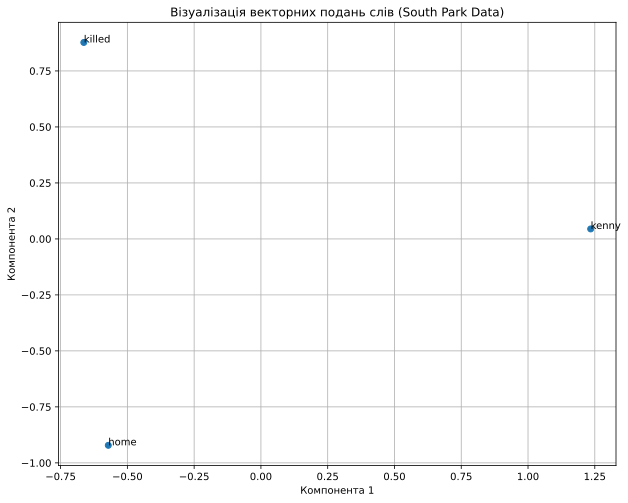


Запуск інтерфейсу користувача:


In [8]:
# 1. Завантаження даних
# Примітка: Для реального виконання краще обмежити кількість рядків для швидкості (наприклад, 20000 слів)
print("Завантаження даних South Park...")
corpus = load_south_park_data('All-seasons.csv', limit_lines=2000)
if not corpus:
    # Якщо файл не знайдено, використовуємо заглушку для демонстрації, щоб код не впав
    corpus = "Oh my god, they killed Kenny! You bastards! I respect your authority. Screw you guys, I'm going home."
    print("Використовується тестовий текст.")

# 2. Токенізація
words = tokenize(corpus)
print(f"Кількість токенів: {len(words)}")

# 3. Створення словників
word2Ind, Ind2word = get_dict(words)
V = len(word2Ind)
print(f"Розмір словника: {V}")

# 4. Параметри навчання
C = 2
N = 50
num_iters = 150 # Зменшено для демонстрації (у методичці 500)
alpha = 0.03
batch_size = 128

# 5. Навчання
print("Початок навчання моделі...")
W1, W2, b1, b2 = gradient_descent(words, word2Ind, N, V, num_iters, alpha, batch_size, C)
print("Навчання завершено!")

# 6. Збереження
save_embeddings(W1, W2, word2Ind, Ind2word, 'south_park_embeddings.pkl')

# 7. Розрахунок фінальних векторів для візуалізації та UI
word_embeddings = (W1.T + W2) / 2.0

# 8. Візуалізація (Слова, характерні для South Park)
words_to_visualize = ['kenny', 'cartman', 'kyle', 'stan', 'south', 'park', 'school', 'home', 'cool', 'dude', 'killed']
visualize_embeddings(word_embeddings, words_to_visualize, word2Ind, n_components=2)

# 9. Запуск UI
print("\nЗапуск інтерфейсу користувача:")
create_ui({w: word_embeddings[word2Ind[w]] for w in word2Ind}, word2Ind)